In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

np.random.seed(42)

In [ ]:
# Here we are going to explore the intersection of data quality, model
# expressivity and data errors

# please copy this code into your own notebook and complete the sections
# as guided by the comments. some of this will be code (marked CODE) others will
# be text (marked TEXT)


In [2]:
# This is your sythentic data generator function

# sbp = systolic blood pressure
# dpb = diastolic blood pressure

def make_fake_patient_data(n=500,swap_error=0.15):

    # make some random input data
    age = np.random.randint(18, 90, n)
    bmi = np.random.normal(27, 5, n).clip(18, 40)
    hr = np.random.normal(75, 10, n).clip(50, 120)

    # this is the ground truth relationship for the fake data
    # we will see if we can learn the true relationship
    sbp_true = (
        0.5*age + 0.8*bmi + 0.05*age*(bmi) + 90 + np.random.normal(0, 10, n)
    )

    # make dbp ~50 less than sbp.
    dbp_true = sbp_true - np.random.normal(50, 10, n)

    # simluate errors in data entry. 'swap_error' is the fraction where whoever recorded it
    # accidentally swapped SBP and DBP
    # make it more likely the higher dbp is

    dbp_prob = (dbp_true - dbp_true.min()) / (dbp_true.max() - dbp_true.min())
    dbp_prob = dbp_prob / dbp_prob.mean()   # normalize so mean dbp value has "swap_risk"
    swap_mask = np.random.rand(n) < (swap_error * dbp_prob)
    sbp, dbp = sbp_true.copy(), dbp_true.copy()
    sbp[swap_mask], dbp[swap_mask] = dbp[swap_mask], sbp[swap_mask]

    # Assemble DataFrame
    df = pd.DataFrame({
        "age": age,
        "hr": hr.round(0).astype(int),
        "sbp": sbp.round(0).astype(int),
        "dbp": dbp.round(0).astype(int),
        "bmi": bmi.round(1)
    })

    return df

age      int64
hr       int64
sbp      int64
dbp      int64
bmi    float64
dtype: object
(500, 5)
age    0
hr     0
sbp    0
dbp    0
bmi    0
dtype: int64


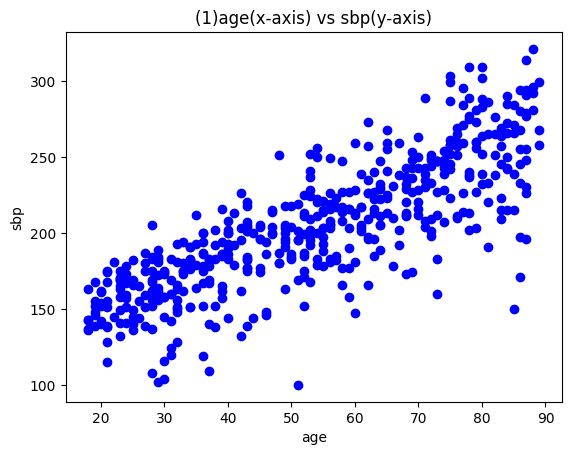

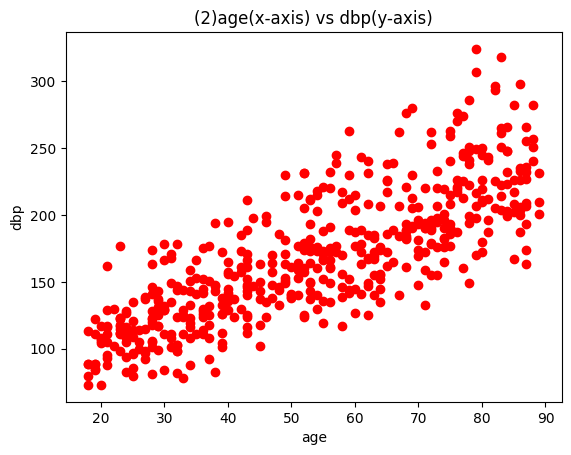

In [44]:
# make a moderately sized data set using the data set generator (500 patients)
# --CODE--
mfpd = make_fake_patient_data()
data = pd.DataFrame(mfpd)
print(data.dtypes)
print(data.shape)
print(data.isna().sum())

# plot age vs SBP and dbp
# --CODE--
# (1)age(x-axis) vs sbp(y-axis)
plt.scatter(data['age'], data['sbp'], c='blue')
plt.xlabel('age')
plt.ylabel('sbp')
plt.title('(1)age(x-axis) vs sbp(y-axis)')
plt.show()

# (2)age(x-axis) vs dbp(y-axis)
plt.scatter(data['age'], data['dbp'], c='red')
plt.xlabel('age')
plt.ylabel('dbp')
plt.title('(2)age(x-axis) vs dbp(y-axis)')
plt.show()

In [35]:
# how many patients (count or %) have impossible blood pressure data? (SBP > DBP)
# --CODE--
num_impossi_bp = len(data[data['sbp'] - data['dbp'] > 0])
sum_ppl = len(data)
print(f'Totally {num_impossi_bp/sum_ppl}%({num_impossi_bp}/{sum_ppl}) may have blood pressure.')

Totally 0.83%(415/500) may have blood pressure.


In [40]:
# let's start with a naive modeling approach.
# what is the relationship between systolic blood pressure and age?
# use a linear model with SBP ~ Age + BMI + HR without cleaning
# --CODE--
formula = 'sbp ~ age + bmi + hr'
model = smf.ols(data=data, formula=formula).fit()
print(model.summary(), model.params)

# compare the true parameters to what's been estimated (intercept, age coeff, bmi coeff, hr coef
# --TEXT--
'''

sbp_true = (
        0.5*age + 0.8*bmi + 0.05*age*(bmi) + 90 + np.random.normal(0, 10, n)
    )

HR: no hr coeff in true sbp formula.
The p-value is greater than 0.05, and its 95% confidence intervals contain 0. Consequently, we cannot conclude that its true value is different from zero; its effects are not statistically significant.

Age and BMI: for age, 1.7791 is larger than 0.5; for bmi, 3.1372 is less than 0.8.
The p-values are less than 0.05, and their 95% confidence intervals do not contain 0. Consequently, their effects are statistically significant. We have strong evidence that age and BMI are associated with systolic blood pressure in this model.

Intercept: 16.3900 is smaller than 90.
'''

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     552.5
Date:                Tue, 09 Sep 2025   Prob (F-statistic):          1.13e-157
Time:                        01:20:33   Log-Likelihood:                -2249.2
No. Observations:                 500   AIC:                             4506.
Df Residuals:                     496   BIC:                             4523.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.3900      9.586      1.710      0.0

In [49]:
# now add the interaction term and report the parameters
# --CODE--
'''
suppose bmi and age will affect sbp.
'''
formula2 = 'sbp ~ age + bmi + hr + age:bmi'
model2 = smf.ols(data=data, formula=formula2)
model2 = model2.fit()
print(model2.summary())

# again compare the true parameters to what's been estimated (intercept, age coeff, bmi coeff, hr coeff)
# --TEXT--
'''
true:
hr: nan
age:0.5
bmi:0.8
age:bmi:0.05

HR: no param in true model.
The p-value is greater than 0.05, and its 95% confidence intervals contain 0. Consequently, we cannot conclude that its true value is different from zero; its effects are not statistically significant.

Age, intercept and BMI:
for age, 0.7268 is larger than true 0.5.
for bmi, 0.0973 is smaller than true 0.8.
for intercept, 73.4452 is smaller than true 90.
The p-values are less than 0.05, and their 95% confidence intervals do not contain 0. Consequently, their effects are statistically significant. We have strong evidence that age and BMI are associated with systolic blood pressure in this model.

age:bmi:
for age:bmi, 0.0360 is smaller than true 0.05.
The effect of age on SBP depends on the person's bmi (and vice-versa). The positive coefficient (0.0360) means that as a person's BMI increases, the effect of aging on their blood pressure becomes even stronger.

Noticed that after adding age:bmi, p-value of intercept becomes significant. It's because of multicollineary.
'''

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     458.7
Date:                Tue, 09 Sep 2025   Prob (F-statistic):          6.15e-165
Time:                        01:42:46   Log-Likelihood:                -2200.9
No. Observations:                 500   AIC:                             4412.
Df Residuals:                     495   BIC:                             4433.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     73.4452     16.015      4.586      0.0

In [54]:
# to show the importance of data set size, repeat the fit of the interaction model with 10,100,1000,10000,100000 fake patients
# --CODE--

def new_make_fake_patient_data(n,swap_error=0.15):

    # make some random input data
    age = np.random.randint(18, 90, n)
    bmi = np.random.normal(27, 5, n).clip(18, 40)
    hr = np.random.normal(75, 10, n).clip(50, 120)

    # this is the ground truth relationship for the fake data
    # we will see if we can learn the true relationship
    sbp_true = (
        0.5*age + 0.8*bmi + 0.05*age*(bmi) + 90 + np.random.normal(0, 10, n)
    )

    # make dbp ~50 less than sbp.
    dbp_true = sbp_true - np.random.normal(50, 10, n)

    # simluate errors in data entry. 'swap_error' is the fraction where whoever recorded it
    # accidentally swapped SBP and DBP
    # make it more likely the higher dbp is

    dbp_prob = (dbp_true - dbp_true.min()) / (dbp_true.max() - dbp_true.min())
    dbp_prob = dbp_prob / dbp_prob.mean()   # normalize so mean dbp value has "swap_risk"
    swap_mask = np.random.rand(n) < (swap_error * dbp_prob)
    sbp, dbp = sbp_true.copy(), dbp_true.copy()
    sbp[swap_mask], dbp[swap_mask] = dbp[swap_mask], sbp[swap_mask]

    # Assemble DataFrame
    df = pd.DataFrame({
        "age": age,
        "hr": hr.round(0).astype(int),
        "sbp": sbp.round(0).astype(int),
        "dbp": dbp.round(0).astype(int),
        "bmi": bmi.round(1)
    })

    return df

num_patients = [10, 100, 1000, 10000, 100000]

for i in num_patients:
  data = new_make_fake_patient_data(i,)
  formula_ = 'sbp ~ age + bmi + hr'
  model_ = smf.ols(data=data, formula=formula_).fit()
  print('\n')
  print(f'--------for model with {i} patients --------\n')
  print(model_.summary())

  formula_2 = 'sbp ~ age + bmi + hr + age:bmi'
  model_2 = smf.ols(data=data, formula=formula_2)
  model_2 = model_2.fit()
  print(model_2.summary())




--------for model with 10 patients --------

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     21.49
Date:                Tue, 09 Sep 2025   Prob (F-statistic):            0.00131
Time:                        02:10:54   Log-Likelihood:                -36.008
No. Observations:                  10   AIC:                             80.02
Df Residuals:                       6   BIC:                             81.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inter

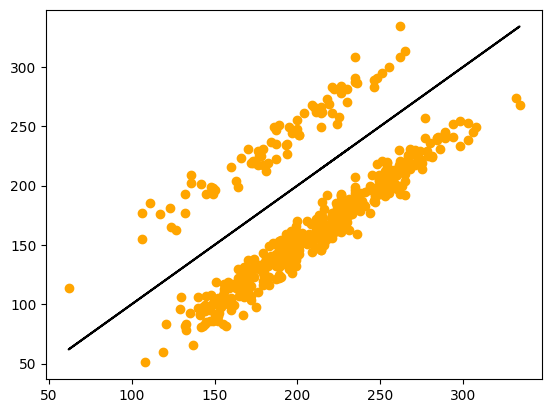

                            OLS Regression Results                            
Dep. Variable:                    sbp   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 1.208e+05
Date:                Tue, 09 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:19:31   Log-Likelihood:            -4.4515e+05
No. Observations:              100000   AIC:                         8.903e+05
Df Residuals:                   99996   BIC:                         8.903e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9692      0.642     34.205      0.0

In [62]:
# now repeat that analysis but drop all impossible data points (sbp < dbp)
# --CODE--

# check if any point is sbp < dbp
data_ = make_fake_patient_data()
plt.scatter(x=data_['sbp'], y=data_['dbp'], c='orange')
plt.plot(data_['sbp'], data_['sbp'], c='black')
plt.show()

data_ = data_[data_['sbp'] >= data_['dbp']]
formula_ = 'sbp ~ age + bmi + hr'
model_ = smf.ols(data=data, formula=formula_).fit()
print(model_.summary())

formula_2 = 'sbp ~ age + bmi + hr + age:bmi'
model_2 = smf.ols(data=data, formula=formula_2)
model_2 = model_2.fit()
print(model_2.summary())

(423, 5)


In [ ]:
# compare and contrast the raw vs cleaned model fits, both accuracy and precision
# --TEXT--

'''
(1)cleaned model(dropped inpossible data points) have better accuracy and precision on both formulas(add interaction or not).
(2)On both 500 patients, parameters of raw model has larger standard error and its p-value are less significant, which means lower accuracy and precision.
(3)For example, cleaned model can have very close parameters in interaction part, its intercept is 90.8092 with age in 0.4581, bmi in 0.7360 and age:bmi 0.0475. All of them are very close to their true parameters. Also, not including hr as it has no significant effect on sbp.
'''

In [ ]:
# why should you think carefully about dropping data?
# --TEXT--

'''
(1)In real data analysis, the patients samples are not as many as ideal situion, usually only 100~1000 samples.
(2)In that case, data cleaning is very important. Not only for following model fitting but also for model explanation.
(3)A great data cleaning can save lots of time and steps for following analysis, such as feature selection and significant effects targeting. And it can also reduce multicollineary and extreme outlier.
'''